# NFL Big Data Bowl 2024


## Attempting to predict direction and pass/run of the play based on pre-snap information.


## Importing dataview libraries


In [295]:
import re

import pandas as pd
import numpy as np

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split

import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [296]:
DATA_ROOT = "../data/"

In [297]:
plays = pd.read_csv(DATA_ROOT + "plays.csv")

## Data cleanup and splitting


In [298]:
def playDescriptionToDirection(play_description):
    fumble = re.search("FUMBLE", play_description)
    if fumble:
        return "FUMBLE"
    play = re.search(
        "(pass (?:short|deep) (?:left|middle|right))|((?:left|right) (?:guard|tackle|end))|(up the middle)",
        play_description,
    )
    play = play.group(0) if play else "UNKNOWN"
    if play == "UNKNOWN":
        return play
    # Simplify the direction
    if "deep" in play:
        play = "PASS DEEP"
    elif "short" in play:
        play = "PASS SHORT"
    elif "end" in play:
        play = "RUN OUTSIDE"
    elif "guard" in play:
        play = "RUN INSIDE"
    elif "tackle" in play:
        play = "RUN INSIDE"
    elif "up the middle" in play:
        play = "RUN INSIDE"
    else:
        play = "UNKNOWN"
    return play

In [299]:
# Add a column for the play direction and whether the play was over 10 yards.
plays["playDirection"] = plays["playDescription"].map(playDescriptionToDirection)
plays["TenPlusYards"] = plays["yardsToGo"] >= 10

# Define the features and target.
numerical_feature_names = ["yardsToGo", "defendersInTheBox", "absoluteYardlineNumber"]
categorical_feature_names = ["offenseFormation", "down"]
binary_feature_names = ["TenPlusYards"]
# binary_feature_names = []
target_name = "playDirection"

df = plays[
    numerical_feature_names
    + categorical_feature_names
    + binary_feature_names
    + [target_name]
].copy()
pre_drop = len(df)
df = df.dropna()
print(f"Dropped {pre_drop - len(df)} rows due to NaN values.")

# Remove fumbled ball as it only occurs 6 times.
fumble_mask = df["playDirection"] == "FUMBLE"
pre_drop = len(df)
df = df[~fumble_mask]
print(f"Dropped {pre_drop - len(df)} rows due to fumbled ball.")

# Remove fumbled ball as it only occurs 6 times.
fumble_mask = df["playDirection"] == "UNKNOWN"
pre_drop = len(df)
df = df[~fumble_mask]
print(f"Dropped {pre_drop - len(df)} rows due to unknown play.")

first_downs = df[(df["down"] == 1)]
df = df[~(df["down"] == 1)]

df[categorical_feature_names] = df[categorical_feature_names].astype("category")
df[binary_feature_names] = df[binary_feature_names].astype("bool")
df = pd.get_dummies(df, columns=categorical_feature_names)
# df[numerical_feature_names] = MinMaxScaler().fit_transform(df[numerical_feature_names])

# Shuffle the data.
cols = list(df.columns)
df = df.sample(frac=1)

target = df.pop(target_name)

# Oversampling
df, target = RandomOverSampler().fit_resample(df, target)
df[target_name] = target
df = df.sample(frac=1)
target = df.pop(target_name)

target = pd.get_dummies(target, columns=[target_name])
labels = target.columns
input_shape = df.shape[1]
output_shape = target.shape[1]
print(f"Input shape: {input_shape}")
print(f"Output shape: {output_shape}")
df.describe()

Dropped 5 rows due to NaN values.
Dropped 118 rows due to fumbled ball.
Dropped 0 rows due to unknown play.
Input shape: 14
Output shape: 4


,yardsToGo,defendersInTheBox,absoluteYardlineNumber
count,12180.000000,12180.000000,12180.000000
mean,7.139984,6.310181,60.839737
std,4.575971,1.050969,22.780786
min,1.000000,1.000000,11.000000
25%,4.000000,6.000000,42.000000
50%,7.000000,6.000000,61.000000
75%,10.000000,7.000000,79.000000
max,38.000000,11.000000,109.000000


In [300]:
# Split into train, validation, and test sets.
x_train, x_test, y_train, y_test = train_test_split(
    df, target, test_size=0.2, random_state=42
)
# x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)
x_train = np.asarray(x_train).astype("float32")
x_test = np.asarray(x_test).astype("float32")
# x_val = np.asarray(x_val).astype("float32")
y_train = np.asarray(y_train).astype("float32")
y_test = np.asarray(y_test).astype("float32")
# y_val = np.asarray(y_val).astype("float32")

In [325]:
def get_neural_net(epochs, batch_size):
    model = tf.keras.Sequential(
        [
            tf.keras.layers.Dense(512, activation="selu", input_shape=(input_shape,)),
            tf.keras.layers.Dropout(0.1),
            tf.keras.layers.Dense(512, activation="selu"),
            tf.keras.layers.Dense(output_shape, activation="softmax"),
        ]
    )
    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    # Fit data to model
    history = model.fit(
        x_train,
        y_train,
        validation_split=0.33,
        batch_size=batch_size,
        epochs=epochs,
        verbose=1,
    )
    return model, history

In [328]:
model, history = get_neural_net(500, 64)

scores = model.evaluate(x_test, y_test, verbose=0)
preds = model.predict(x_test)
print("Accuracy: %.2f%%" % (scores[1] * 100))

Epoch 1/500
102/102 [==============================] - 2s 16ms/step - loss: 2.6792 - accuracy: 0.2961 - val_loss: 1.3944 - val_accuracy: 0.3818
Epoch 2/500
102/102 [==============================] - 2s 15ms/step - loss: 1.4362 - accuracy: 0.3457 - val_loss: 1.3128 - val_accuracy: 0.3933
Epoch 3/500
102/102 [==============================] - 1s 15ms/step - loss: 1.3740 - accuracy: 0.3722 - val_loss: 1.3495 - val_accuracy: 0.3809
Epoch 4/500
102/102 [==============================] - 2s 15ms/step - loss: 1.3624 - accuracy: 0.3790 - val_loss: 1.2882 - val_accuracy: 0.3918
Epoch 5/500
102/102 [==============================] - 2s 15ms/step - loss: 1.3270 - accuracy: 0.3733 - val_loss: 1.4381 - val_accuracy: 0.3371
Epoch 6/500
102/102 [==============================] - 2s 15ms/step - loss: 1.3597 - accuracy: 0.3684 - val_loss: 1.3258 - val_accuracy: 0.3697
Epoch 7/500
102/102 [==============================] - 1s 15ms/step - loss: 1.3391 - accuracy: 0.3738 - val_loss: 1.2694 - val_accuracy:

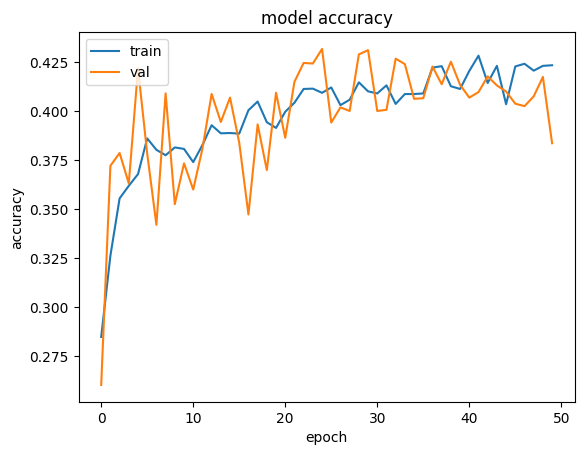

              precision    recall  f1-score   support

   PASS DEEP       0.44      0.47      0.46       612
  PASS SHORT       0.39      0.31      0.34       542
  RUN INSIDE       0.75      0.08      0.15       630
 RUN OUTSIDE       0.35      0.69      0.47       652

    accuracy                           0.39      2436
   macro avg       0.48      0.39      0.35      2436
weighted avg       0.49      0.39      0.35      2436



In [327]:
plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

preds_labels = []
for pred in preds:
    preds_labels.append(labels[max(range(len(pred)), key=pred.__getitem__)])

reals_labels = []
for real in y_test:
    reals_labels.append(labels[max(range(len(real)), key=real.__getitem__)])

print(classification_report(reals_labels, preds_labels, zero_division=0))

In [ ]:
# model.save_weights('./checkpoints/good_model')